In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
min_perc = 80

sig_threshes = [0.05, 0.01, 0.001]
sig_annots = ['*', '**', '***']

## Human

In [8]:
ca = cerberus.read(cerberus_h5)

In [12]:
# add library level triplets
ca = cerberus.read(cerberus_h5)
sg = swan.read(swan_file)
filt_ab_df = pd.read_csv(filt_ab, sep='\t')
obs_col = 'dataset'
min_tpm = 1

df = ca.get_expressed_triplets(sg,
                               obs_col=obs_col,
                               min_tpm=min_tpm,
                               source='dataset_det')

Read in graph from ../../proc_revisions/data/human/lr/swan/swan_graph.p


In [14]:
df.to_csv('library_triplets.tsv', sep='\t')

In [28]:
df = pd.read_csv('library_triplets.tsv', sep='\t')

In [29]:
# limit to protein coding
g_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
g_df = g_df[['gid_stable', 'biotype_category']]
g_df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
pc_gids = g_df.loc[g_df.biotype_category=='protein_coding'].gid.tolist()
print(len(ca.triplets.index))
df = df.loc[df.gid.isin(pc_gids)]
print(len(df.index))

1278516
1378628


In [30]:
df = df.copy(deep=True)
df = df.loc[df.source=='dataset_det']
df = df[['dataset', 'sector', 'gid']].groupby(['dataset', 'sector']).nunique().reset_index().rename({'gid':'n_genes'}, axis=1)
df = df.pivot(columns='dataset', index='sector', values='n_genes')
df = df.transpose()


In [31]:
meta = pd.read_csv(lib_meta, sep='\t')
meta = meta[['dataset', 'sample', 'RIN']]
df = df.merge(meta, how='left', left_index=True, right_on='dataset')


,mixed,simple,splicing,tes,tss,dataset,sample,RIN
0,4692,2211,1531,1933,673,a673_1_1,a673,9.8
1,4066,2399,1494,1741,534,a673_1_2,a673,9.8
2,3689,2948,783,1589,379,adrenal_gland_1_1,adrenal_gland,9.8
3,4269,3000,1301,1867,700,adrenal_gland_2_1,adrenal_gland,NaN
4,3559,3196,731,1457,422,adrenal_gland_3_1,adrenal_gland,9.4


% genes in tss vs. RIN spearman rho: -0.3740011590274597, pval:0.0009485035589467057
% genes in tss vs. RIN pearson r: -0.3806205484228784, pval:0.0009485035589467057


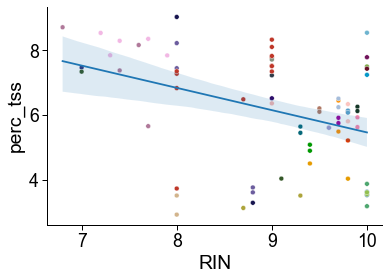

% genes in splicing vs. RIN spearman rho: 0.23399193477085858, pval:0.04332763381287906
% genes in splicing vs. RIN pearson r: 0.20803741620506544, pval:0.04332763381287906


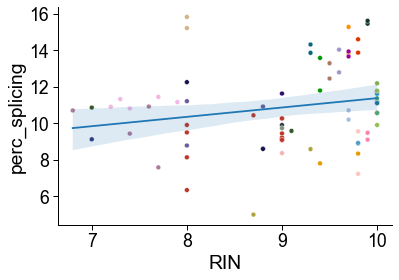

% genes in tes vs. RIN spearman rho: 0.2404670933811945, pval:0.03769761589899712
% genes in tes vs. RIN pearson r: 0.2585867809502306, pval:0.03769761589899712


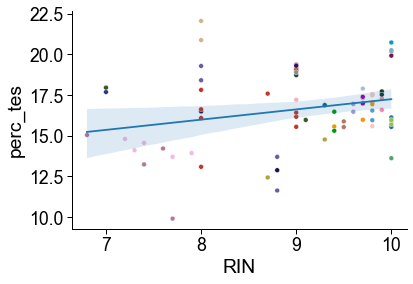

% genes in mixed vs. RIN spearman rho: 0.3042895728406865, pval:0.007949140883613062
% genes in mixed vs. RIN pearson r: 0.2410252951790324, pval:0.007949140883613062


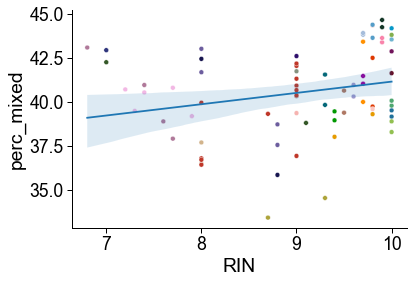

% genes in simple vs. RIN spearman rho: -0.19699919639657748, pval:0.09025526281989113
% genes in simple vs. RIN pearson r: -0.16531634756052865, pval:0.09025526281989113


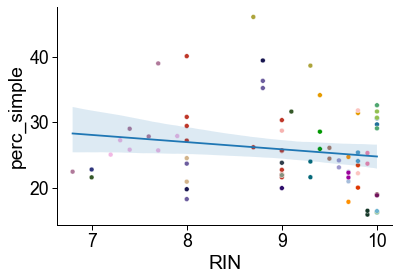

<Figure size 432x288 with 0 Axes>

In [39]:
sectors =  get_sector_colors()[1]
df['n_tot'] = df[sectors].sum(axis=1)
df = df.loc[df.RIN.notnull()]
c_dict, order = get_biosample_colors()
for s in sectors:
    df[f'perc_{s}'] = (df[s]/df['n_tot'])*100
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    
    y = f'perc_{s}'
    x = 'RIN'
    ax = sns.scatterplot(df, y=y, x=x, hue='sample', palette=c_dict)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend_.remove()
    
    rho, p = st.spearmanr(df[x].tolist(), df[y].tolist())
    print(f'% genes in {s} vs. RIN spearman rho: {rho}, pval:{p}')
    r, p2 = st.pearsonr(df[x].tolist(), df[y].tolist())
    print(f'% genes in {s} vs. RIN pearson r: {r}, pval:{p}')
    
                        
    ax = sns.regplot(df, y=y, x=x, scatter=False)
    plt.show()
    plt.clf()
    
    


## What about without brain?

75
66
% genes in tss vs. RIN spearman rho: -0.18997043741727326, pval:0.12656494352219153
% genes in tss vs. RIN pearson r: -0.18894296715263426, pval:0.12656494352219153


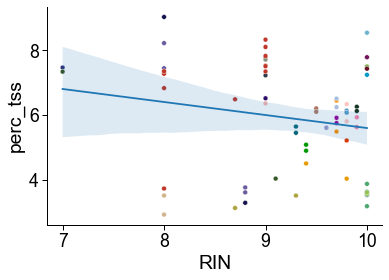

% genes in splicing vs. RIN spearman rho: 0.264541612884191, pval:0.03183444752906465
% genes in splicing vs. RIN pearson r: 0.22592759774604415, pval:0.03183444752906465


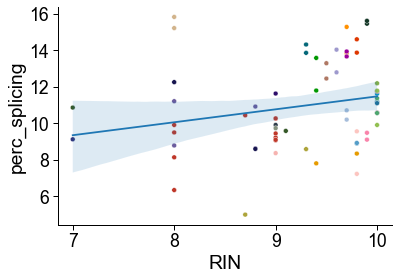

% genes in tes vs. RIN spearman rho: -0.031073075088836864, pval:0.8043855818028498
% genes in tes vs. RIN pearson r: -0.04316379553727582, pval:0.8043855818028498


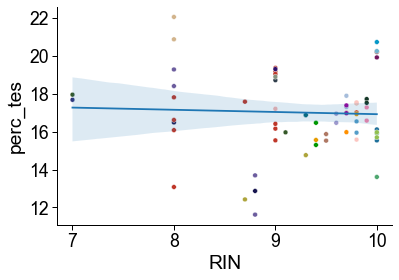

% genes in mixed vs. RIN spearman rho: 0.35244183409286955, pval:0.003704403817671945
% genes in mixed vs. RIN pearson r: 0.3010118387761022, pval:0.003704403817671945


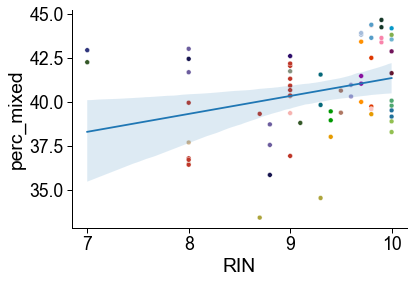

% genes in simple vs. RIN spearman rho: -0.16453172235807664, pval:0.1867882595299708
% genes in simple vs. RIN pearson r: -0.1462487272469758, pval:0.1867882595299708


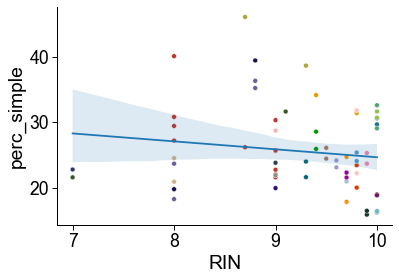

<Figure size 432x288 with 0 Axes>

In [40]:
sectors =  get_sector_colors()[1]
df['n_tot'] = df[sectors].sum(axis=1)
df = df.loc[df.RIN.notnull()]
print(len(df.index))
df = df.loc[~df['sample'].str.contains('brain')]
print(len(df.index))

c_dict, order = get_biosample_colors()
for s in sectors:
    df[f'perc_{s}'] = (df[s]/df['n_tot'])*100
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    
    y = f'perc_{s}'
    x = 'RIN'
    ax = sns.scatterplot(df, y=y, x=x, hue='sample', palette=c_dict)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend_.remove()
    
    rho, p = st.spearmanr(df[x].tolist(), df[y].tolist())
    print(f'% genes in {s} vs. RIN spearman rho: {rho}, pval:{p}')
    r, p2 = st.pearsonr(df[x].tolist(), df[y].tolist())
    print(f'% genes in {s} vs. RIN pearson r: {r}, pval:{p}')
    
                        
    ax = sns.regplot(df, y=y, x=x, scatter=False)
    plt.show()
    plt.clf()
    
    
